# Source code : https://github.com/justinengelmann/GANbasedOversampling


In [1]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve,confusion_matrix, auc,roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from datetime import datetime, date, time
from functools import reduce
import catboost
import pandas as pd
import numpy as np
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from dataloader import load_data
from helpers import get_cat_dims
from models import WGANGP
import logging
logging.getLogger().setLevel(logging.INFO)
warnings.simplefilter(action='ignore', category=FutureWarning)
# 원래
from models_copy import WGANGP
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=5,random_state=seed,n_repeats=4)
pd.set_option('mode.chained_assignment',  None)
pd.set_option('display.max_columns',500)

pd.set_option('display.max_rows',500)
merge_df = pd.read_csv('merge_df.csv')
merge_df = merge_df.fillna(merge_df.mean())



In [2]:
# 원래
from models_copy import WGANGP
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=5,random_state=seed,n_repeats=4)

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)


for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

        #SMOTE로 타겟의 분포를 균등하게 조절
    # smote = SMOTE(random_state=42)
    # x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    

    num_cols = list(x_train_sk.columns)
    cat_dims=[]
    cat_cols = []

    gan = WGANGP(write_to_disk=False, # whether to create an output folder. Plotting will be surpressed if flase
                compute_metrics_every=1250, print_every=2500, plot_every=10000,
                num_cols = num_cols, cat_dims=cat_dims,
                # pass the one hot encoder to the GAN to enable count plots of categorical variables
                transformer=None,
                # pass column names to enable
                cat_cols=cat_cols,
                use_aux_classifier_loss=True,
                d_updates_per_g=3, gp_weight=15)

    gan.fit(x_train_sk, y=y_train_sk.values, 
            condition=True,
            epochs=300,  
            batch_size=64,
            netG_kwargs = {'hidden_layer_sizes': (2048,1024), 
                            'n_cross_layers': 1,
                            'cat_activation': 'gumbel_softmax',
                            'num_activation': 'none',
                            'condition_num_on_cat': False, 
                            'noise_dim': 25, 
                            'normal_noise': False,
                            'activation':  'leaky_relu',
                            'reduce_cat_dim': False,
                            'use_num_hidden_layer': True,
                            'layer_norm':False,},
            netD_kwargs = {'hidden_layer_sizes': (2048,1024,512),
                            'n_cross_layers': 2,
                            'embedding_dims': 'auto',
                            'activation':  'leaky_relu',
                            'sigmoid_activation': False,
                            'noisy_num_cols': True,
                            'layer_norm':True,}
        )
    x_train_sk, y_train_sk = gan.resample(x_train_sk, y=y_train_sk)
    
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    x_train_sk = pd.DataFrame(x_train_sk)
    x_train_sk.columns = x_val_sk.columns
    y_train_sk = pd.DataFrame(y_train_sk.astype(dtype='int64'))
    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    
    ft_importance_values = model.feature_importances_

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])

    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0632
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:12.536 LD:15.056 D:18.399 GP:0.223 AC: 0.300 RMSEAVG:0.121 NUM:0.121 SynTraiAuc:0.417 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.059804131831393846
roc_auc_score :  0.7833333333333333
acc :  0.7241379310344828
sensitivity :  0.8
specificity :  0.7083333333333334
pr_auc :  0.5031632782540041 

[[34 14]
 [ 2  8]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0635
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:11.689 LD:12.737 D:13.064 GP:0.022 AC: 0.325 RMSEAVG:0.117 NUM:0.117 SynTraiAuc:0.792 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.36711566036385274
roc_auc_score :  0.7875
acc :  0.7068965517241379
sensitivity :  0.9
specificity :  0.6666666666666666
pr_auc :  0.5232490337005741 

[[32 16]
 [ 1  9]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0556
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:9.952 LD:13.887 D:18.456 GP:0.305 AC: 0.328 RMSEAVG:0.127 NUM:0.127 SynTraiAuc:0.625 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.27224772306689154
roc_auc_score :  0.8020833333333334
acc :  0.896551724137931
sensitivity :  0.7
specificity :  0.9375
pr_auc :  0.43123323149796455 

[[45  3]
 [ 3  7]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0484
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:10.888 LD:13.732 D:14.752 GP:0.068 AC: 0.303 RMSEAVG:0.123 NUM:0.123 SynTraiAuc:0.604 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    153
1.0    153
dtype: int64
Youden index threshold :  0.32074098224675374
roc_auc_score :  0.6757369614512472
acc :  0.8793103448275862
sensitivity :  0.4444444444444444
specificity :  0.9591836734693877
pr_auc :  0.42982195434255815 

[[47  2]
 [ 5  4]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0631
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:11.757 LD:14.501 D:15.596 GP:0.073 AC: 0.304 RMSEAVG:0.115 NUM:0.115 SynTraiAuc:0.479 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.13225772094768065
roc_auc_score :  0.599537037037037
acc :  0.7543859649122807
sensitivity :  0.4444444444444444
specificity :  0.8125
pr_auc :  0.19757832213173993 

[[39  9]
 [ 5  4]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0577
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:11.893 LD:14.126 D:16.576 GP:0.163 AC: 0.317 RMSEAVG:0.136 NUM:0.136 SynTraiAuc:0.354 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.058712676774011825
roc_auc_score :  0.59375
acc :  0.41379310344827586
sensitivity :  1.0
specificity :  0.2916666666666667
pr_auc :  0.23940338490815133 

[[14 34]
 [ 0 10]]


INFO:root:Finished training auxiliary classifier. ACC: 0.9946 AUC: 0.9667 BCE: 0.2404
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:11.798 LD:16.422 D:19.889 GP:0.231 AC: 0.300 RMSEAVG:0.113 NUM:0.113 SynTraiAuc:0.688 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.24449423908399417
roc_auc_score :  0.5916666666666667
acc :  0.7931034482758621
sensitivity :  0.5
specificity :  0.8541666666666666
pr_auc :  0.25076721468622554 

[[41  7]
 [ 5  5]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0627
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:10.639 LD:14.046 D:17.367 GP:0.221 AC: 0.364 RMSEAVG:0.119 NUM:0.119 SynTraiAuc:0.750 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.043673446536449216
roc_auc_score :  0.6895833333333333
acc :  0.5172413793103449
sensitivity :  1.0
specificity :  0.4166666666666667
pr_auc :  0.3643870631162559 

[[20 28]
 [ 0 10]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0593
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:-0.619 LD:14.829 D:17.453 GP:0.175 AC: 0.373 RMSEAVG:0.114 NUM:0.114 SynTraiAuc:0.208 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    153
1.0    153
dtype: int64
Youden index threshold :  0.46983523952252965
roc_auc_score :  0.5192743764172336
acc :  0.8448275862068966
sensitivity :  0.2222222222222222
specificity :  0.9591836734693877
pr_auc :  0.19582670584918188 

[[47  2]
 [ 7  2]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0560
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:11.292 LD:15.101 D:19.110 GP:0.267 AC: 0.307 RMSEAVG:0.112 NUM:0.112 SynTraiAuc:0.479 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.05650692914456145
roc_auc_score :  0.7731481481481481
acc :  0.5964912280701754
sensitivity :  1.0
specificity :  0.5208333333333334
pr_auc :  0.32270626411426007 

[[25 23]
 [ 0  9]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0626
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:11.632 LD:14.326 D:18.602 GP:0.285 AC: 0.306 RMSEAVG:0.119 NUM:0.119 SynTraiAuc:0.188 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.07758624519267249
roc_auc_score :  0.5833333333333333
acc :  0.6551724137931034
sensitivity :  0.6
specificity :  0.6666666666666666
pr_auc :  0.2859860590341857 

[[32 16]
 [ 4  6]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0560
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:4.540 LD:13.053 D:14.401 GP:0.090 AC: 0.391 RMSEAVG:0.124 NUM:0.124 SynTraiAuc:0.625 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.35878061063835465
roc_auc_score :  0.6708333333333334
acc :  0.5517241379310345
sensitivity :  0.9
specificity :  0.4791666666666667
pr_auc :  0.35464453961567044 

[[23 25]
 [ 1  9]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0605
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:10.201 LD:13.346 D:13.960 GP:0.041 AC: 0.300 RMSEAVG:0.113 NUM:0.113 SynTraiAuc:0.312 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.03178445911065296
roc_auc_score :  0.7104166666666667
acc :  0.5689655172413793
sensitivity :  0.9
specificity :  0.5
pr_auc :  0.37627393591370895 

[[24 24]
 [ 1  9]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0523
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:11.118 LD:14.112 D:16.271 GP:0.144 AC: 0.300 RMSEAVG:0.131 NUM:0.131 SynTraiAuc:0.667 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    153
1.0    153
dtype: int64
Youden index threshold :  0.16972332831950349
roc_auc_score :  0.5510204081632653
acc :  0.6379310344827587
sensitivity :  0.5555555555555556
specificity :  0.6530612244897959
pr_auc :  0.2787426507950689 

[[32 17]
 [ 4  5]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
INFO:root:Finished training auxiliary classifier. ACC: 0.9946 AUC: 0.9935 BCE: inf
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:7.956 LD:13.635 D:17.245 GP:0.241 AC: 0.325 RMSEAVG:0.137 NUM:0.137 SynTraiAuc:0.583 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.42309068903004726
roc_auc_score :  0.41666666666666663
acc :  0.24561403508771928
sensitivity :  1.0
specificity :  0.10416666666666667
pr_auc :  0.143955386206916 

[[ 5 43]
 [ 0  9]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0661
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:12.913 LD:15.622 D:16.472 GP:0.057 AC: 0.305 RMSEAVG:0.123 NUM:0.123 SynTraiAuc:0.542 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.07894055963485518
roc_auc_score :  0.6125
acc :  0.7413793103448276
sensitivity :  0.7
specificity :  0.75
pr_auc :  0.22787017225611872 

[[36 12]
 [ 3  7]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0597
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:7.137 LD:13.398 D:16.021 GP:0.175 AC: 0.349 RMSEAVG:0.113 NUM:0.113 SynTraiAuc:0.854 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.3888122744037815
roc_auc_score :  0.6687500000000001
acc :  0.8275862068965517
sensitivity :  0.5
specificity :  0.8958333333333334
pr_auc :  0.28297704586331496 

[[43  5]
 [ 5  5]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0567
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:8.397 LD:13.600 D:15.926 GP:0.155 AC: 0.304 RMSEAVG:0.117 NUM:0.117 SynTraiAuc:0.646 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.15740492351395313
roc_auc_score :  0.63125
acc :  0.6551724137931034
sensitivity :  0.7
specificity :  0.6458333333333334
pr_auc :  0.22714147547948388 

[[31 17]
 [ 3  7]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0475
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:18.202 LD:28.346 D:36.020 GP:0.512 AC: 0.315 RMSEAVG:0.127 NUM:0.127 SynTraiAuc:0.333 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    153
1.0    153
dtype: int64
Youden index threshold :  0.21727661490789435
roc_auc_score :  0.6462585034013606
acc :  0.6379310344827587
sensitivity :  0.6666666666666666
specificity :  0.6326530612244898
pr_auc :  0.22569323641331768 

[[31 18]
 [ 3  6]]


INFO:root:Finished training auxiliary classifier. ACC: 1.0000 AUC: 1.0000 BCE: 0.0558
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 3 iters per epoch to reach target of 900.


INFO:root:Finished training after 900/900.


[  900/900] LG:12.628 LD:15.506 D:17.547 GP:0.136 AC: 0.302 RMSEAVG:0.119 NUM:0.119 SynTraiAuc:0.104 RFAcc:1.000  
 변화된 값의 분포 :
 0.0    154
1.0    154
dtype: int64
Youden index threshold :  0.3463260218066808
roc_auc_score :  0.7870370370370371
acc :  0.7894736842105263
sensitivity :  0.8888888888888888
specificity :  0.7708333333333334
pr_auc :  0.3230728220323218 

[[37 11]
 [ 1  8]]


In [3]:
print('proba_score',np.mean(proba_score))
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.6546839569160997
re_score 0.7211111111111111
specifi_score 0.6612457482993198


[0.7833333333333333,
 0.7875,
 0.8020833333333334,
 0.6757369614512472,
 0.599537037037037,
 0.59375,
 0.5916666666666667,
 0.6895833333333333,
 0.5192743764172336,
 0.7731481481481481,
 0.5833333333333333,
 0.6708333333333334,
 0.7104166666666667,
 0.5510204081632653,
 0.41666666666666663,
 0.6125,
 0.6687500000000001,
 0.63125,
 0.6462585034013606,
 0.7870370370370371]

In [4]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP

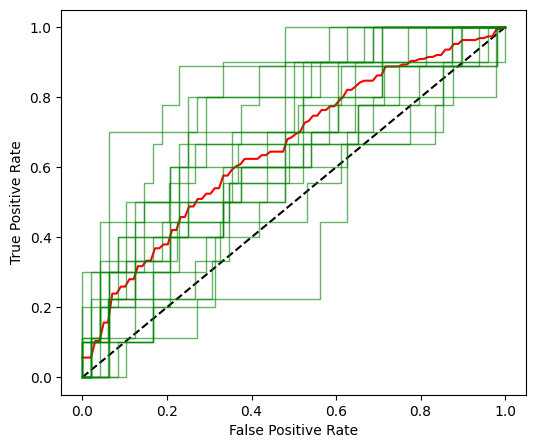

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

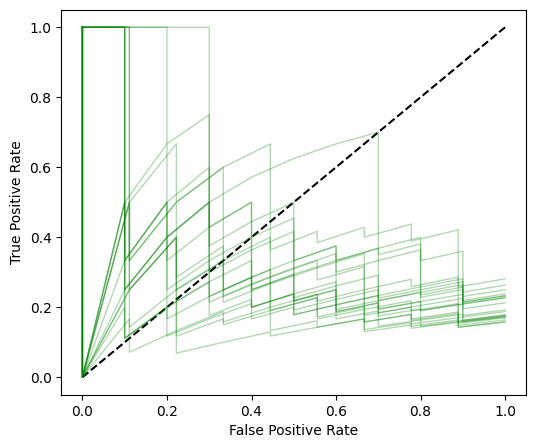

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)